# Mixed formulation for the Poisson equation

This demo illustrates how to solve Poisson equation using a mixed
(two-field) formulation. In particular, it illustrates how to

* Use mixed and non-continuous finite element spaces.
* Set essential boundary conditions for subspaces and $H(\mathrm{div})$ spaces.


```{admonition} Download sources
:class: download

* {download}`Python script <./demo_mixed-poisson.py>`
* {download}`Jupyter notebook <./demo_mixed-poisson.ipynb>`
```

## Equation and problem definition

An alternative formulation of Poisson equation can be formulated by
introducing an additional (vector) variable, namely the (negative)
flux: $\sigma = \nabla u$. The partial differential equations
then read

$$
\begin{align}
  \sigma - \nabla u &= 0 \quad {\rm in} \ \Omega, \\
  \nabla \cdot \sigma &= - f \quad {\rm in} \ \Omega,
\end{align}
$$
with boundary conditions

$$
  u = u_0 \quad {\rm on} \ \Gamma_{D},  \\
  \sigma \cdot n = g \quad {\rm on} \ \Gamma_{N}.
$$

The same equations arise in connection with flow in porous media, and are
also referred to as Darcy flow. Here $n$ denotes the outward pointing normal
vector on the boundary. Looking at the variational form, we see that the
boundary condition for the flux ($\sigma \cdot n = g$) is now an essential
boundary condition (which should be enforced in the function space), while
the other boundary condition ($u = u_0$) is a natural boundary condition
(which should be applied to the variational form). Inserting the boundary
conditions, this variational problem can be phrased in the general form: find
$(\sigma, u) \in \Sigma_g \times V$ such that

$$
   a((\sigma, u), (\tau, v)) = L((\tau, v))
   \quad \forall \ (\tau, v) \in \Sigma_0 \times V,
$$

where the variational forms $a$ and $L$ are defined as

$$
\begin{align}
  a((\sigma, u), (\tau, v)) &=
    \int_{\Omega} \sigma \cdot \tau + \nabla \cdot \tau \ u
  + \nabla \cdot \sigma \ v \ {\rm d} x, \\
  L((\tau, v)) &= - \int_{\Omega} f v \ {\rm d} x
  + \int_{\Gamma_D} u_0 \tau \cdot n  \ {\rm d} s,
\end{align}
$$
and $\Sigma_g = \{ \tau \in H({\rm div})$ such that $\tau \cdot n|_{\Gamma_N}
= g \}$ and $V = L^2(\Omega)$.

To discretize the above formulation, two discrete function spaces $\Sigma_h
\subset \Sigma$ and $V_h \subset V$ are needed to form a mixed function space
$\Sigma_h \times V_h$. A stable choice of finite element spaces is to let
$\Sigma_h$ be the Brezzi-Douglas-Marini elements of polynomial order
$k$ and let $V_h$ be discontinuous elements of polynomial order $k-1$.

We will use the same definitions of functions and boundaries as in the
demo for {doc}`the Poisson equation <demo_poisson>`. These are:

* $\Omega = [0,1] \times [0,1]$ (a unit square)
* $\Gamma_{D} = \{(0, y) \cup (1, y) \in \partial \Omega\}$
* $\Gamma_{N} = \{(x, 0) \cup (x, 1) \in \partial \Omega\}$
* $u_0 = 0$
* $g = \sin(5x)$   (flux)
* $f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$  (source term)

## Implementation

In [21]:
try:
    from petsc4py import PETSc
    import dolfinx
    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This demo requires petsc4py.")
    exit(0)

from mpi4py import MPI
import numpy as np

from basix.ufl import element, mixed_element
from dolfinx import default_real_type, fem, io, mesh
from dolfinx.fem.petsc import LinearProblem
from ufl import (Measure, SpatialCoordinate, TestFunctions, TrialFunctions,
                 div, inner, sin, cos, pi, FacetNormal, ds, grad, conditional, And, ge, le)
import ufl
import matplotlib.pyplot as plt
from dolfinx import geometry

# Define domain corners
Lx = 10.0
Ly = 10.0
p0 = [0.0, 0.0]
p1 = [Lx, Ly]

# Triangular mesh with 64x64 cells
nx = 256
ny = 256
msh = mesh.create_rectangle(
    MPI.COMM_WORLD,
    [p0, p1],
    [nx, ny],
    cell_type=mesh.CellType.quadrilateral
)

k = 2
# Q_el = element("RTCF", msh.basix_cell(), k, dtype=default_real_type)
# P_el = element("DG", msh.basix_cell(), k - 1, dtype=default_real_type)
# V_el = mixed_element([Q_el, P_el])
Q_el = fem.functionspace(msh, ("RT", k))
P_el = fem.functionspace(msh, ("DG", k-1))
V = ufl.MixedFunctionSpace(Q_el, P_el)
# V = fem.functionspace(msh, V_el)

(dsigma, du) = TrialFunctions(V)
(tau, v) = TestFunctions(V)
sigma = fem.Function(Q_el, name="sigma")
u = fem.Function(P_el, name="u")

x = SpatialCoordinate(msh)
n = FacetNormal(msh)

kappa = 1


# --- Tag boundary facets: LEFT=1, RIGHT=2, BOTTOM=3, TOP=4
LEFT, RIGHT, BOTTOM, TOP = 1, 2, 3, 4

def on_left(x):   return np.isclose(x[0], 0.0)
def on_right(x):  return np.isclose(x[0], Lx)
def on_bottom(x): return np.isclose(x[1], 0.0)
def on_top(x):    return np.isclose(x[1], Ly)

tdim = msh.topology.dim
msh.topology.create_connectivity(tdim-1, tdim)

facets_left   = mesh.locate_entities_boundary(msh, tdim-1, on_left)
facets_right  = mesh.locate_entities_boundary(msh, tdim-1, on_right)
facets_bottom = mesh.locate_entities_boundary(msh, tdim-1, on_bottom)
facets_top    = mesh.locate_entities_boundary(msh, tdim-1, on_top)

facet_indices = np.concatenate([facets_left, facets_right, facets_bottom, facets_top])
facet_values  = np.concatenate([
    np.full_like(facets_left,   LEFT),
    np.full_like(facets_right,  RIGHT),
    np.full_like(facets_bottom, BOTTOM),
    np.full_like(facets_top,    TOP)
])

facet_tags = mesh.meshtags(msh, tdim-1, facet_indices, facet_values)

dx = Measure("dx", domain=msh, metadata={"quadrature_degree": 12})
ds = Measure("ds", domain=msh, subdomain_data=facet_tags, metadata={"quadrature_degree": 12})

# Side-specific traces (as you proposed)
# u_D1 = cos(3*pi*0) * cos(3*pi*x[1])*0 + 10      # LEFT   (x=0)
# u_D2 = cos(3*pi*1) * cos(3*pi*x[1])*0 + 1  # RIGHT  (x=1)
# u_D3 = cos(3*pi*x[0]) * cos(3*pi*0)*0 + 1     # BOTTOM (y=0)
# u_D4 = cos(3*pi*x[0]) * cos(3*pi*1)*0 + 10    # TOP    (y=1)
u_D1 = 10      # LEFT   (x=0)
u_D2 = 1  # RIGHT  (x=1)
u_D3 = 1     # BOTTOM (y=0)
u_D4 = 10    # TOP    (y=1)

k_bg = 1
k_hi = 100
# h = max(Lx/nx, Ly/ny)
# target_cells_across = 1.5
# w = target_cells_across * h   # replaces your fixed 0.4
w = 0.1

# tips of the diagonal fracture
xa, ya = (2,8)    # tuple or list (x_a, y_a)
xb, yb = (8,3)    # tuple or list (x_b, y_b)

# direction vector of fracture
ddx = xb - xa
ddy = yb - ya
len2 = ddx*ddx + ddy*ddy

# vector from tip1 to point x
vx = x[0] - xa
vy = x[1] - ya

# projection of (vx,vy) onto fracture direction, normalized to [0,1]
t = (vx*ddx + vy*ddy) / len2

# coordinates of closest point on the segment
px = xa + t*ddx
py = ya + t*ddy

# squared distance from x to segment
dist2 = (x[0] - px)**2 + (x[1] - py)**2

# inside if projection is within [0,1] and distance < (w/2)
in_seg = And(ge(t, 0.0), le(t, 1.0))
in_band = le(dist2, (0.5*w)**2)

mask = conditional(And(in_seg, in_band), 1.0, 0.0)

kappa     = k_bg + (k_hi - k_bg) * mask
# kappa = 1
# ----------------------------
# Fracture model: scalar kappa(x)
# ----------------------------
# y_f   = 4.5     # center y of fracture
# w     = 0.14     # thickness
# x_a   = 1.0     # left extent
# x_b   = 8.0      # right extent

# k_mat = fem.Constant(msh, default_real_type(1.0))    # matrix perm
# k_frac = fem.Constant(msh, default_real_type(1e-4))   # fracture perm
# # scalar values
# # k_mat  = 10000.0   # background matrix permeability
# # k_frac = 1.0       # fracture permeability

# # Indicator = 1 in fracture band, 0 otherwise
# in_y = And(ge(x[1], y_f - w/2), le(x[1], y_f + w/2))
# in_x = And(ge(x[0], x_a),       le(x[0], x_b))
# Ifrac = conditional(And(in_y, in_x), 1.0, 0.0)

# Scalar permeability
# kappa = k_mat + Ifrac * (k_frac - k_mat)
kappa_inv = 1.0 / kappa

# Choose a visualization space (DG0 = cellwise constant, or CG1 for smooth interpolation)
vis_kappa=False
if vis_kappa:
    V0 = fem.functionspace(msh, ("DG", 0))
    kappa_fun = fem.Function(V0, name="kappa")

    # Interpolate the UFL expression into this function
    expr = fem.Expression(kappa, V0.element.interpolation_points())
    kappa_fun.interpolate(expr)

    # Regular sampling grid
    nx_plot, ny_plot = nx, ny
    xs = np.linspace(0.0, Lx, nx_plot)
    ys = np.linspace(0.0, Ly, ny_plot)
    X, Y = np.meshgrid(xs, ys)
    pts2d = np.column_stack([X.ravel(), Y.ravel()])

    # Pad to 3D (eval requires (N,3) coordinates)
    pts = np.zeros((pts2d.shape[0], 3), dtype=np.float64)
    pts[:, :2] = pts2d

    # Build bounding-box tree for point → cell lookup
    tdim = msh.topology.dim
    bbt = geometry.bb_tree(msh, tdim)
    collisions = geometry.compute_collisions_points(bbt, pts)
    cells = geometry.compute_colliding_cells(msh, collisions, pts)

    # Convert ragged cell array to flat (pick first valid cell, else -1)
    cell_ids = np.full(pts.shape[0], -1, dtype=np.int32)
    # Case A: AdjacencyList return (not directly iterable)
    if hasattr(cells, "links"):
        for i in range(pts.shape[0]):
            hits = cells.links(i)          # numpy array of candidate cell ids
            if len(hits) > 0:
                cell_ids[i] = int(hits[0]) # pick the first hit

    # Case B: Python list/sequence of arrays
    else:
        for i, hits in enumerate(cells):
            if len(hits) > 0:
                cell_ids[i] = int(hits[0])

    # Evaluate kappa_fun at points
    vals = np.zeros((pts.shape[0], 1), dtype=np.float64)
    vals = kappa_fun.eval(pts, cell_ids)
    Kplot = vals.reshape((ny_plot, nx_plot))

    if MPI.COMM_WORLD.rank == 0:
        # nx_plot, ny_plot = nx, ny
        # xs = np.linspace(0, Lx, nx_plot)
        # ys = np.linspace(0, Ly, ny_plot)
        # X, Y = np.meshgrid(xs, ys)
        # pts = np.array([X.ravel(), Y.ravel()]).T

        # vals = np.zeros((pts.shape[0], 1), dtype=np.float64)
        # kappa_fun.eval(vals, pts)

        # Kplot = vals.reshape((ny_plot, nx_plot))

        plt.figure(figsize=(6,5))
        im = plt.imshow(Kplot, extent=[0, Lx, 0, Ly],
                        origin="lower", cmap="plasma", aspect="equal")
        # plt.colorbar(im, label="kappa")
        # im = plt.imshow(Kcell[::-1, :], extent=[0, Lx, 0, Ly], origin="lower", aspect="equal")
        plt.colorbar(im, label="kappa")
        plt.title("Permeability field κ(x)")
        plt.xlabel("x"); plt.ylabel("y")
        plt.tight_layout()
        plt.show()

# Permeability (unit here). If you have kappa, use: f = -div(kappa*grad(u_ex))
# f = -div(kappa*grad(u_ex))
f = 0

# Mixed variational form (κ = I here). Replace inner(sigma,tau) by inner(kappa_inv*sigma,tau) if needed.
a = inner(kappa_inv*sigma, tau) * dx - inner(u, div(tau)) * dx + inner(div(sigma), v) * dx

# RHS with piecewise boundary integrals:
# L = inner(f, v) * dx \
#     - u_D1 * inner(tau, n) * ds(LEFT) \
#     - u_D2 * inner(tau, n) * ds(RIGHT) \
#     - u_D3 * inner(tau, n) * ds(BOTTOM) \
#     - u_D4 * inner(tau, n) * ds(TOP)

L = f * v * dx \
    - u_D1 * inner(tau, n) * ds(LEFT) \
    - u_D2 * inner(tau, n) * ds(RIGHT) \
    - u_D3 * inner(tau, n) * ds(BOTTOM) \
    - u_D4 * inner(tau, n) * ds(TOP)

# No essential (strong) BCs; Dirichlet handled via boundary term above
bcs = []

# problem = LinearProblem(
#     a, L, bcs=bcs,
#     petsc_options={
#         "ksp_type": "preonly",
#         "pc_type": "lu",
#         "pc_factor_mat_solver_type": "superlu_dist",
#     },
# )
# problem = LinearProblem(
#     a, L, bcs=bcs,
#     petsc_options={
#         "ksp_type": "gmres",
#         "ksp_rtol": 1e-8,
#         "ksp_max_it": 10000,
#         "pc_type": "ilu",
#         "pc_factor_levels": 1,   # try 0 or 1
#         # "ksp_monitor": None, "ksp_converged_reason": None,
#     },
# )



# try:
#     w_h = problem.solve()
# except PETSc.Error as e:  # type: ignore
#     if e.ierr == 92:
#         print("The required PETSc solver/preconditioner is not available. Exiting.")
#         print(e)
#         exit(0)
#     else:
#         raise e

# sigma_h, u_h = w_h.split()

# with io.XDMFFile(msh.comm, "mixed_poisson_fracture/u.xdmf", "w") as file:
#     file.write_mesh(msh)
#     file.write_function(u_h)

print('cell size h: ', Lx/nx)


cell size h:  0.0390625


In [22]:
from dolfinx.fem import petsc
F = a - L
residual = ufl.extract_blocks(F)
jac = ufl.derivative(F, sigma, dsigma) + ufl.derivative(F, u, du)
J = ufl.extract_blocks(jac)
nlp = petsc.NonlinearProblem(
    residual,
    u=[sigma, u],
    J=J,
    bcs=bcs,
    # entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

  0 SNES Function norm 2.274027264568e+02
  1 SNES Function norm 5.180287526743e-12
Converged in 1 Newton iterations


/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


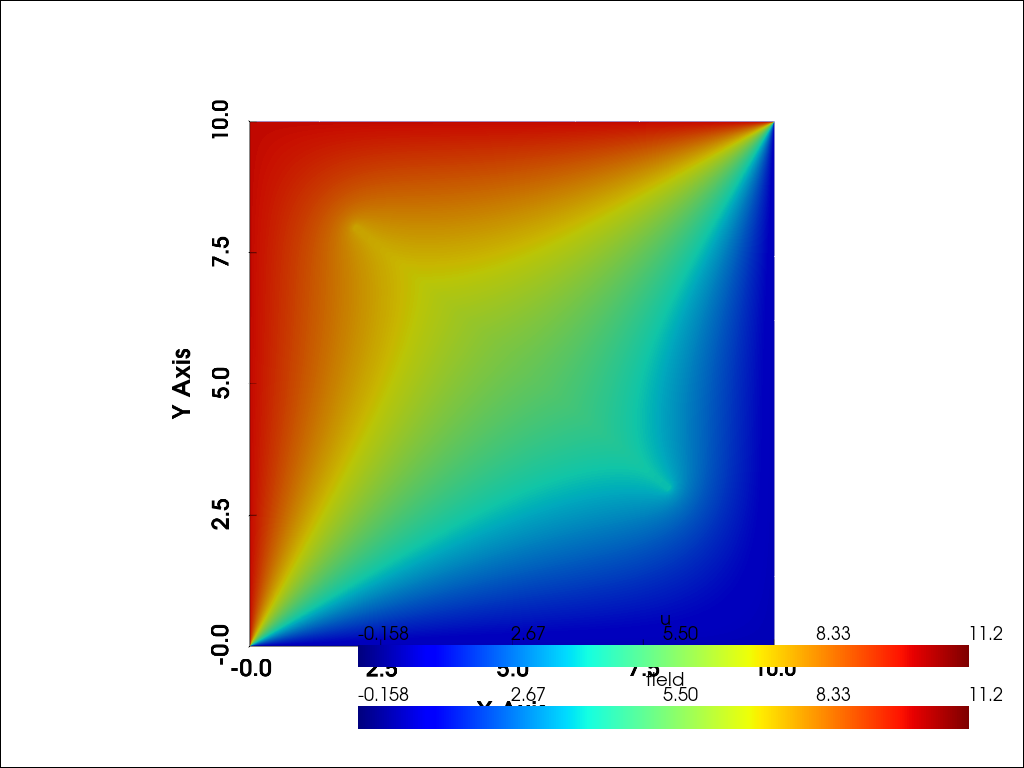

In [23]:
import numpy as np
import pyvista as pv
import dolfinx
from dolfinx import plot

# --- helper: build a PyVista grid from a scalar Function (CG or DG) ---
def function_to_pyvista_grid(u):
    # Newer dolfinx uses create_vtk_mesh; fall back to vtk_mesh if needed
    try:
        topology, cell_types, geometry = plot.create_vtk_mesh(u.function_space)
    except AttributeError:
        topology, cell_types, geometry = plot.vtk_mesh(u.function_space)

    grid = pv.UnstructuredGrid(topology, cell_types, geometry)

    # Attach scalar values on points
    # For scalar fields, u.x.array is 1D of length n_dofs
    values = u.x.array
    # If the FE space is vector-valued, drop to first component (not expected here)
    if values.ndim > 1:
        values = values.reshape(-1)
    grid.point_data["field"] = values.real  # use .real in case of complex
    return grid

# --- Build PyVista grids for p_m and p_f ---
# grid_sigma = function_to_pyvista_grid(sigma)
grid_u = function_to_pyvista_grid(u)

# Optional: consistent ranges so the color scales match (remove if you prefer autoscale)
vmin = grid_u.point_data["field"].min()
vmax = grid_u.point_data["field"].max()

# --- Plot side-by-side, inspired by your style (wireframe + shaded) ---
plotter = pv.Plotter(shape=(1, 1), border=True)

# Left: p_m
plotter.subplot(0, 0)
plotter.add_mesh(grid_u.copy(deep=True), style="wireframe", color="b")
plotter.add_mesh(
    grid_u, scalars="field", show_edges=False, lighting=True, clim=[vmin, vmax],cmap='jet'
)
plotter.add_scalar_bar(title="u")
plotter.show_bounds()
plotter.view_xy()

# Right: p_f
# plotter.subplot(0, 1)
# plotter.add_mesh(grid_u.copy(deep=True), style="wireframe", color="b")
# plotter.add_mesh(
#     grid_pf, scalars="field", show_edges=True, lighting=True, clim=[vmin, vmax]
# )
# plotter.add_scalar_bar(title="p_f")
# plotter.show_bounds()
# plotter.view_xy()

# Link cameras so rotations/zooms match
plotter.link_views()
plotter.show()


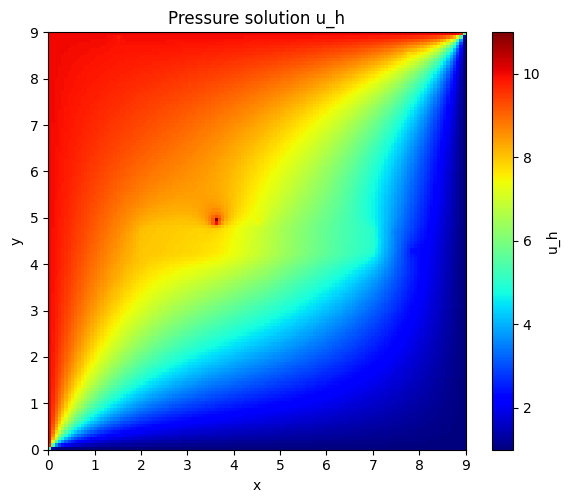

In [17]:
if MPI.COMM_WORLD.rank == 0:
    # Define sample points (e.g. 200x200 grid)
    nx_plot, ny_plot = nx, ny
    xs = np.linspace(0, Lx, nx_plot)
    ys = np.linspace(0, Ly, ny_plot)
    X, Y = np.meshgrid(xs, ys)
    pts2d = np.column_stack([X.ravel(), Y.ravel()])

    # Pad to 3D (eval requires (N,3) coordinates)
    pts = np.zeros((pts2d.shape[0], 3), dtype=np.float64)
    pts[:, :2] = pts2d

    # Build bounding-box tree for point → cell lookup
    tdim = msh.topology.dim
    bbt = geometry.bb_tree(msh, tdim)
    collisions = geometry.compute_collisions_points(bbt, pts)
    cells = geometry.compute_colliding_cells(msh, collisions, pts)

    # Convert ragged cell array to flat (pick first valid cell, else -1)
    cell_ids = np.full(pts.shape[0], -1, dtype=np.int32)
    # Case A: AdjacencyList return (not directly iterable)
    if hasattr(cells, "links"):
        for i in range(pts.shape[0]):
            hits = cells.links(i)          # numpy array of candidate cell ids
            if len(hits) > 0:
                cell_ids[i] = int(hits[0]) # pick the first hit

    # Case B: Python list/sequence of arrays
    else:
        for i, hits in enumerate(cells):
            if len(hits) > 0:
                cell_ids[i] = int(hits[0])

    # Evaluate u_h at those points
    vals = np.zeros((pts.shape[0], 1), dtype=np.float64)
    vals = u_h.eval(pts, cell_ids)

    Uplot = vals.reshape((ny_plot, nx_plot))

    # Plot
    plt.figure(figsize=(6, 5))
    im = plt.imshow(Uplot, extent=[0, Lx, 0, Ly],
                    origin="lower", cmap="jet", aspect="equal")
    plt.colorbar(im, label="u_h")
    plt.title("Pressure solution u_h")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.show()

In [74]:
from dolfinx import fem
from dolfinx.fem.petsc import assemble_matrix
from ufl import Form
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# 1) Assemble the bilinear form to a PETSc Mat
A_petsc = assemble_matrix(fem.form(a), bcs=[])   # add your Dirichlet BCs if any
A_petsc.assemble()

# 2) Convert PETSc Mat -> SciPy CSR
IA, JA, data = A_petsc.getValuesCSR()
A = csr_matrix((data, JA, IA), shape=A_petsc.getSize())

# 3) Estimate cond_2(A) via extreme singular values:
#    σ_max = sqrt(λ_max(A^T A)),  σ_min = sqrt(λ_min(A^T A))
AtA = (A.T).dot(A)
lam_max = eigsh(AtA, k=1, which="LA", return_eigenvectors=False)[0]
lam_min = eigsh(AtA, k=1, which="SA", return_eigenvectors=False)[0]

if lam_min <= 0:
    print("Matrix is singular/near-singular → condition number is infinite/undefined.")
else:
    cond2 = np.sqrt(lam_max / lam_min)
    print("cond_2(A) ≈", cond2)


ArpackNoConvergence: ARPACK error -1: No convergence (124161 iterations, 0/1 eigenvectors converged)

In [30]:
from dolfinx import fem
from petsc4py import PETSc

# Assemble global matrix and RHS
Aglob = fem.petsc.assemble_matrix(fem.form(a), bcs=[])
Aglob.assemble()
bglob = fem.petsc.assemble_vector(fem.form(L))

# Field index sets (0: sigma block, 1: u block)
# Suppose W = V * Q is your mixed function space
V_dofs = V.sub(0).dofmap.list  # global dof indices for sigma
Q_dofs = V.sub(1).dofmap.list   # global dof indices for u

is_sig = PETSc.IS().createGeneral(V_dofs, comm=V.mesh.comm)
is_u     = PETSc.IS().createGeneral(Q_dofs, comm=V.mesh.comm)

# Extract block matrices
A00 = Aglob.createSubMatrix(is_sig, is_sig)   # A
A01 = Aglob.createSubMatrix(is_sig, is_u)     # B^T
A10 = Aglob.createSubMatrix(is_u,   is_sig)   # B
A11 = Aglob.createSubMatrix(is_u,   is_u)     # (zero in your formulation)

# Split the RHS
b_sigma = bglob.getSubVector(is_sig)          # size = dim(V)
b_u     = bglob.getSubVector(is_u)            # size = dim(Q)


In [35]:
tau, v = TestFunctions(V)
# --- Block bilinear forms ---
A00_form = inner(kappa_inv * sigma, tau) * dx          # (σ, τ) block
A01_form = - inner(u, div(tau)) * dx                   # (u, τ) = B^T
A10_form =   inner(div(sigma), v) * dx                 # (σ, v) = B
# A11 is structurally zero for standard mixed Darcy:
#   either build an explicit empty PETSc Mat with correct sizes,
#   or (simpler) skip it and remember it is zero.

# --- Block RHS forms ---
# First row (vector eqn): natural “Dirichlet” via flux terms on boundaries
L_sigma_form = -( u_D1 * inner(tau, n) * ds(LEFT)
                + u_D2 * inner(tau, n) * ds(RIGHT)
                + u_D3 * inner(tau, n) * ds(BOTTOM)
                + u_D4 * inner(tau, n) * ds(TOP) )

# Second row (scalar eqn): volume source
L_u_form = inner(f, v) * dx
# L_u_form     = f * v * dx

# --- Assemble blocks ---
A00 = fem.petsc.assemble_matrix(fem.form(A00_form)); A00.assemble()
A01 = fem.petsc.assemble_matrix(fem.form(A01_form)); A01.assemble()
A10 = fem.petsc.assemble_matrix(fem.form(A10_form)); A10.assemble()

# Create an explicit zero A11 (optional, many codes just keep None)
Q, Psub = V.sub(0), V.sub(1)
nloc_p = Psub.dofmap.index_map.size_local  * Psub.dofmap.index_map_bs
nglo_p = Psub.dofmap.index_map.size_global * Psub.dofmap.index_map_bs

A11 = PETSc.Mat().createAIJ([[nloc_p, nglo_p], [nloc_p, nglo_p]], comm=msh.comm)
A11.setUp()

# RHS blocks
# Mixed test functions
# tau, v = TestFunctions(V)

# Mixed RHS
L_form_mixed = (-( u_D1*inner(tau, n)*ds(LEFT)
                 + u_D2*inner(tau, n)*ds(RIGHT)
                 + u_D3*inner(tau, n)*ds(BOTTOM)
                 + u_D4*inner(tau, n)*ds(TOP) )
                + f * v * dx)

b_mixed = fem.petsc.assemble_vector(fem.form(L_form_mixed))

# Build the index array for the pressure subspace dofs
P, dofs_P = V.sub(1).collapse()   # 'dofs_P' maps P-dofs into V-dofs
Q, dofs_Q = V.sub(0).collapse()

# Extract subvectors
b_u_arr     = b_mixed.getValues(dofs_P)
b_sigma_arr = b_mixed.getValues(dofs_Q)

# If you want PETSc Vecs for each block:
b_u_vec = PETSc.Vec().createMPI(P.dofmap.index_map.size_global * P.dofmap.index_map_bs,
                                P.dofmap.index_map.size_local  * P.dofmap.index_map_bs,
                                comm=msh.comm)
b_u_vec.setValues(range(len(dofs_P)), b_u_arr)
b_u_vec.assemble()

b_sigma_vec = PETSc.Vec().createMPI(Q.dofmap.index_map.size_global * Q.dofmap.index_map_bs,
                                    Q.dofmap.index_map.size_local  * Q.dofmap.index_map_bs,
                                    comm=msh.comm)
b_sigma_vec.setValues(range(len(dofs_Q)), b_sigma_arr)
b_sigma_vec.assemble()

b_sigma = b_sigma_vec
b_u = b_u_vec


In [36]:
# 4) Define an A^{-1} “apply” (direct or AMG)
kspA = PETSc.KSP().create(A00.comm)
kspA.setOperators(A00)
# Direct:
# kspA.setType("preonly"); kspA.getPC().setType("lu"); kspA.getPC().setFactorSolverType("superlu_dist")
# Or iterative:
kspA.setType("cg"); kspA.getPC().setType("hypre"); kspA.setTolerances(rtol=1e-10)
kspA.setUp()

def Ainv_apply(y, x):  # y := A^{-1} x
    kspA.solve(x, y)

In [37]:
# 5) Build the Schur “shell” S x = B A^{-1} B^T x (and RHS r)
work_sig1 = A00.createVecRight()
work_sig2 = A00.createVecRight()

def Schur_mult(Sctx, x, y):
    # y = B A^{-1} (B^T x)
    A01.mult(x, work_sig1)        # work_sig1 = B^T x
    Ainv_apply(work_sig2, work_sig1)
    A10.mult(work_sig2, y)        # y = B work_sig2

class SchurCtx:
    def mult(self, A, x, y): Schur_mult(self, x, y)

S = PETSc.Mat().createPython([A11.getSize(), A11.getSize()], comm=A11.comm)
S.setPythonContext(SchurCtx()); S.setUp()

tmp_sig = A00.createVecRight()
Ainv_apply(tmp_sig, b_sigma)
r = A11.createVecRight()
A10.mult(tmp_sig, r)
r.axpy(-1.0, b_u)  # r = B A^{-1} b_sigma - b_u

Error: error code 75
[0] KSPSolve() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1755537683/work/src/ksp/ksp/interface/itfunc.c:1091
[0] KSPSolve_Private() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1755537683/work/src/ksp/ksp/interface/itfunc.c:914
[0] KSPSolve_CG() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1755537683/work/src/ksp/ksp/impls/cg/cg.c:162
[0] VecCopy() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1755537683/work/src/vec/vec/interface/vector.c:1801
[0] VecCopyAsync_Private() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1755537683/work/src/vec/vec/interface/vector.c:1720
[0] Arguments are incompatible
[0] Incompatible vector local lengths parameter # 1 local size 33024 != parameter # 2 local size 49408

In [ ]:
# 6) Solve S u = r (CG) and reconstruct σ = A^{-1}(b_sigma - B^T u)
kspS = PETSc.KSP().create(S.comm)
kspS.setOperators(S)
kspS.setType("cg"); kspS.getPC().setType("none")
kspS.setTolerances(rtol=1e-10, max_it=2000)
kspS.setUp()

u_vec = A11.createVecRight()
kspS.solve(r, u_vec)

rhs_sig = A00.createVecRight()
A01.mult(u_vec, rhs_sig)     # rhs_sig = B^T u
rhs_sig.scale(-1.0); rhs_sig.axpy(1.0, b_sigma)
sigma_vec = A00.createVecRight()
Ainv_apply(sigma_vec, rhs_sig)

In [ ]:
# 7) Scatter back to a Function(W)
# --- Scatter (sigma,u) back into the global mixed vector ---
xglob = Aglob.createVecRight()
xglob.set(0.0)

# Write sigma into the sigma-slot
sub_sigma = xglob.getSubVector(is_sig)   # view into xglob
sigma_vec.copy(sub_sigma)                  # sub_sigma := sigma_vec
xglob.restoreSubVector(is_sig, sub_sigma)

# Write u into the u-slot
sub_u = xglob.getSubVector(is_u)           # view into xglob
u_vec.copy(sub_u)                          # sub_u := u_vec
xglob.restoreSubVector(is_u, sub_u)

xglob.assemblyBegin(); xglob.assemblyEnd()

# Map to Function(W)
w = fem.Function(V)
with w.x.petsc_vec.localForm() as wl, xglob.localForm() as xl:
    wl.array[:] = xl.array
sigma_h, u_h = w.split()


In [ ]:
u_h

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 1), Basix element (P, quadrilateral, 0, gll_warped, unset, True, float64, [])), 14)

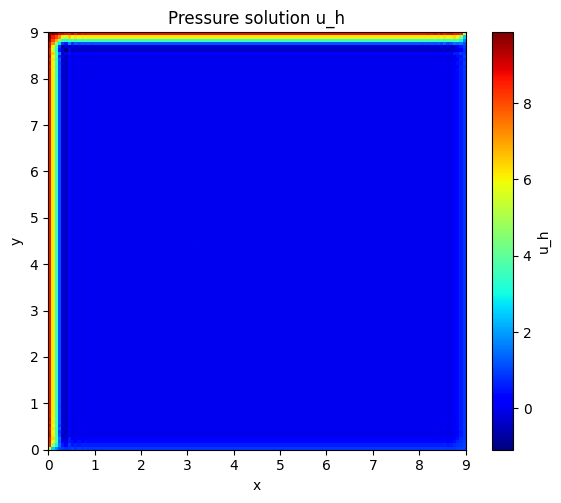

In [ ]:
if MPI.COMM_WORLD.rank == 0:
    # Define sample points (e.g. 200x200 grid)
    nx_plot, ny_plot = nx, ny
    xs = np.linspace(0, Lx, nx_plot)
    ys = np.linspace(0, Ly, ny_plot)
    X, Y = np.meshgrid(xs, ys)
    pts2d = np.column_stack([X.ravel(), Y.ravel()])

    # Pad to 3D (eval requires (N,3) coordinates)
    pts = np.zeros((pts2d.shape[0], 3), dtype=np.float64)
    pts[:, :2] = pts2d

    # Build bounding-box tree for point → cell lookup
    tdim = msh.topology.dim
    bbt = geometry.bb_tree(msh, tdim)
    collisions = geometry.compute_collisions_points(bbt, pts)
    cells = geometry.compute_colliding_cells(msh, collisions, pts)

    # Convert ragged cell array to flat (pick first valid cell, else -1)
    cell_ids = np.full(pts.shape[0], -1, dtype=np.int32)
    # Case A: AdjacencyList return (not directly iterable)
    if hasattr(cells, "links"):
        for i in range(pts.shape[0]):
            hits = cells.links(i)          # numpy array of candidate cell ids
            if len(hits) > 0:
                cell_ids[i] = int(hits[0]) # pick the first hit

    # Case B: Python list/sequence of arrays
    else:
        for i, hits in enumerate(cells):
            if len(hits) > 0:
                cell_ids[i] = int(hits[0])

    # Evaluate u_h at those points
    vals = np.zeros((pts.shape[0], 1), dtype=np.float64)
    vals = u_h.eval(pts, cell_ids)

    Uplot = vals.reshape((ny_plot, nx_plot))

    # Plot
    plt.figure(figsize=(6, 5))
    im = plt.imshow(Uplot, extent=[0, Lx, 0, Ly],
                    origin="lower", cmap="jet", aspect="equal")
    plt.colorbar(im, label="u_h")
    plt.title("Pressure solution u_h")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.show()